# Implementation of Using Convolution Filters with clustering techniques (DBSCAN) and Understanding of CNN via layer wise relevance propagation (or similar techniques) 

In [1]:
%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


# Load data
build it using python class

add normalize function in class

In [2]:
%time
class Waveform():
    
    def __init__(self, path=None, no_classes=None):
        if path is None:
            raise ValueError("Insert file path!")
        if no_classes is None:
            raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = -(pmtall[i]-pedestal_sum[i])
#         number = 
        
        # random labelling(test purposes)
        self.waveform = normalize(pmtall,axis=1,norm="l1")
        self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return (self.waveform[idx],self.label[idx])


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


In [3]:
no_classes = 3
dataset = Waveform(path="Run9goodDataQ_dualgate.root", no_classes=no_classes)

In [4]:
BATCH_SIZE = 1000
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

# #Testing#
# for i in dataset:
#     print(len(i[0]),len(i[1]))
# for i in data_loader:
#     print(i[0].size())
#     print(i[1].size())
# print(len(dataset))


In [5]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) 

65675


In [6]:
n_batches
del dataset
print(n_batches)

65


# Define CNN structure
using an autoencoder for self-training, taking encoder part or decoder part for features learning

normalization issue?

In [ ]:
print(torch.randn(10,10).size())

In [7]:
# BATCH_SIZE=2000

from torch import nn
from torch.autograd import Variable
   
# Autoencoder
# WIP!
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
#         self.cv1 = nn.Conv1d(1, 32, kernel_size=32, stride=4, padding=1)
#         self.pl1 = nn.MaxPool1d(2, stride=4)
#         self.cv21 = nn.Conv1d(32, 32, kernel_size=32, stride=4, padding=1)
#         self.pl21 = nn.MaxPool1d(2, stride=4)
#         self.cv22 = nn.Conv1d(32, 32, kernel_size=32, stride=4, padding=1)
#         self.pl22 = nn.MaxPool1d(2, stride=4)

#         self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=64, stride=4)
#         self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=48, stride=4)
#         self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=40, stride=8)
# #         self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=12, stride=4)
        
        self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=2, stride=2, padding=1)
        self.pl1 = nn.MaxPool1d(2, stride=3)
        self.cv21 = nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=1)
        self.pl21 = nn.MaxPool1d(2, stride=3)
        self.cv22 = nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=1)
        self.pl22 = nn.MaxPool1d(2, stride=3)

        self.ct1 = nn.ConvTranspose1d(64, 64, kernel_size=2, stride=3)
        self.ct2 = nn.ConvTranspose1d(64, 64, kernel_size=4, stride=3, padding=0)
        self.ct3 = nn.ConvTranspose1d(64, 1, kernel_size=4, stride=4, padding=0)
#         self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=12, stride=4)

    def encoder(self, x):
        h0 = self.norm(x)
        h1 = F.relu(self.pl1(self.cv1(h0)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.relu(self.ct1(z))
        h3 = F.relu(self.ct2(h3))
#         h3 = F.sigmoid(self.ct3(h3))
        return F.relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
        

# CNN = Classifier(1, no_classes=3, kernel_size=8, no_filters=32, 
#                  padding=4, maxpool=2, batch_size=BATCH_SIZE) 

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

# print(CNN)
# for parameter in CNN.parameters():
#     print(parameter.size())

print("Autoencoder")

GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cv1): Conv1d(1, 32, kernel_size=(2,), stride=(2,), padding=(1,))
  (pl1): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 64, kernel_size=(2,), stride=(2,), padding=(1,))
  (pl21): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 64, kernel_size=(2,), stride=(2,), padding=(1,))
  (pl22): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(64, 64, kernel_size=(2,), stride=(3,))
  (ct2): ConvTranspose1d(64, 64, kernel_size=(4,), stride=(3,))
  (ct3): ConvTranspose1d(64, 1, kernel_size=(4,), stride=(4,))
)
torch.Size([1])
torch.Size([1])
torch.Size([32, 1, 2])
torch.Size([32])
torch.Size([64, 32, 2])
torch.Size([64])
torch.Size([64, 32, 2])
torch.Size([64])
torch.Size([64, 64, 2])
torch.Size([64])
torch.Size([64, 64, 4])
torch.Size([

In [ ]:
    
print("#DUMMY WORKSPACE")    

from sklearn.cluster import DBSCAN
print(data_loader)

# TEST = CNN(Variable(torch.randn(BATCH_SIZE,1,4096)))
TEST = GEN(Variable(torch.randn(BATCH_SIZE,1,4096)))
DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())

print(DATA.size())
# print(TEST[2].size())
# print(TEST[0].detach().numpy())


# print("DBSCAN")
# db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
# print(db.core_sample_indices_)
# print(db.labels_)

### training
transform to Torch.Variable

In [8]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

# Dummy code workspace

In [ ]:
output = Variable(torch.randn(10,120))
target = Variable(torch.FloatTensor(10).uniform_(0, 120).long())
print(torch.FloatTensor(10))
print(torch.FloatTensor(10).uniform_(0,1).long())
# print(output,target)

loss = criterion(output,target)
print(loss)

In [12]:
%time
N_EPOCHS = 10
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, (waveform,label) in enumerate(data_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = to_var(waveform.view(batch_size,1,4096))
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


#             print(loss.data[0])
        
            if (batch_number +1)%5 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
#             print(GEN.state_dict())
            torch.save(GEN.state_dict(), "GEN_%d_%d.pkl"%(epoch,N_EPOCHS))
#             print(GEN.encoder(training_data)[0].size())
except KeyboardInterrupt:
    print('Training ended early.')



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/home/danny/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/10], Step[5/65], loss=0.006498
Epoch[1/10], Step[10/65], loss=0.006552
Epoch[1/10], Step[15/65], loss=0.006493
Epoch[1/10], Step[20/65], loss=0.006529
Epoch[1/10], Step[25/65], loss=0.006531
Epoch[1/10], Step[30/65], loss=0.006488
Epoch[1/10], Step[35/65], loss=0.006499
Epoch[1/10], Step[40/65], loss=0.006479
Epoch[1/10], Step[45/65], loss=0.006513
Epoch[1/10], Step[50/65], loss=0.006488
Epoch[1/10], Step[55/65], loss=0.006500
Epoch[1/10], Step[60/65], loss=0.006496
Epoch[1/10], Step[65/65], loss=0.006448
Epoch[2/10], Step[5/65], loss=0.006467
Epoch[2/10], Step[10/65], loss=0.006469
Epoch[2/10], Step[15/65], loss=0.006497
Epoch[2/10], Step[20/65], loss=0.006505
Epoch[2/10], Step[25/65], loss=0.006487
Epoch[2/10], Step[30/65], loss=0.006497
Epoch[2/10], Step[35/65], loss=0.006474
Epoch[2/10], Step[40/65], loss=0.006457
Epoch[2/10], Step[45/65], loss=0.006481
Epoch[2/10], Step[50/65], loss=0.006546
Epoch[2/10], Step[55/65], loss=0.006459
Epoch[2/10], Step[60/65], loss=0.006468
Ep

# Testing output of models

In [ ]:
Features = torch.randn(41260,32,14)
print(Features[:1000].size())


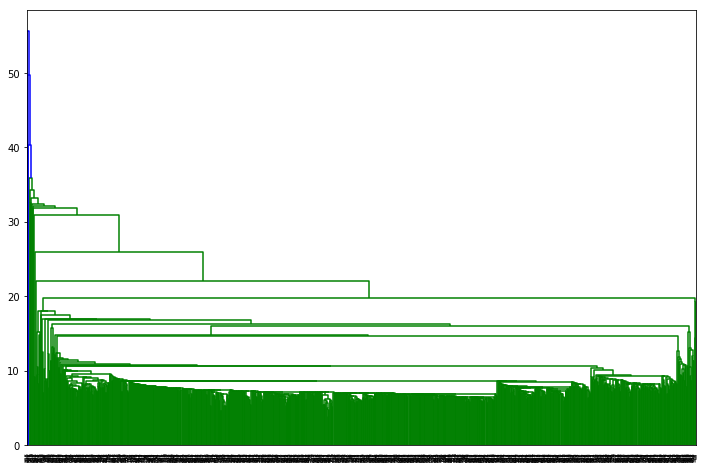

0 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00061336 -0.00044109 -0.00044109 ... -0.00029743 -0.00029743
 -0.0002981 ]


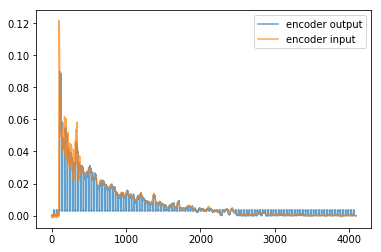

1 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00028232 -0.00014012 -0.00070891 ... -0.00020344 -0.00020205
 -0.00019761]


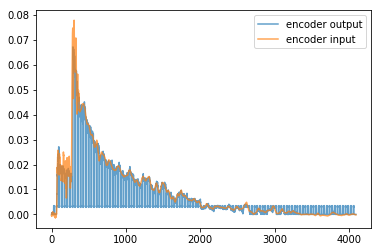

2 (1, 4096) (1, 4096)
[0.00103666 0.00170147 0.00110212 ... 0.         0.         0.        ]
[ 4.9095778e-03  3.9590015e-03  3.1985405e-03 ... -1.0916774e-04
 -8.6888613e-05 -8.2432787e-05]


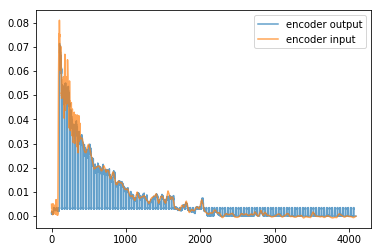

3 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 6.9232883e-05 -1.7314138e-04  6.9232883e-05 ... -7.8937323e-05
 -7.1836512e-05 -7.3019983e-05]


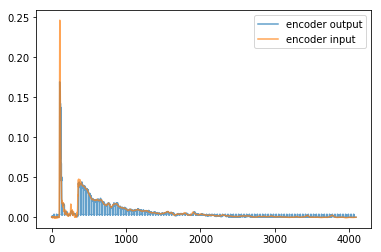

4 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 0.00047266 -0.00089586 -0.00028763 ...  0.0002563   0.00025808
  0.00026788]


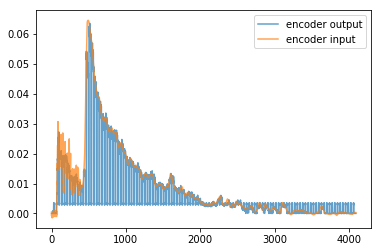

5 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 3.2424484e-04  3.2424484e-04  1.5441020e-04 ... -6.8663612e-05
 -9.0888068e-05 -1.0780519e-04]


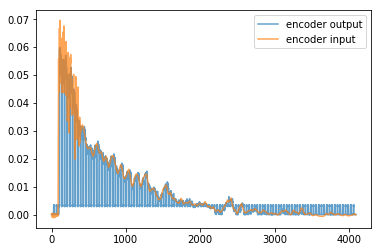

6 (1, 4096) (1, 4096)
[0.00155657 0.00197071 0.00178411 ... 0.         0.         0.        ]
[-0.00071639 -0.00026799 -0.00071639 ... -0.00069625 -0.00068705
 -0.00068004]


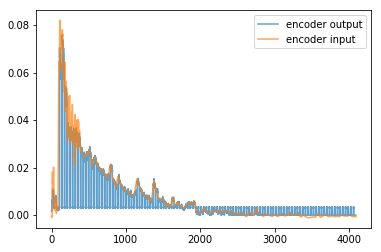

7 (1, 4096) (1, 4096)
[0.00375421 0.0041483  0.00382715 ... 0.         0.         0.        ]
[-3.6701307e-04  1.6480964e-04  1.5830036e-03 ...  3.5662590e-05
  4.2241129e-05  4.6395991e-05]


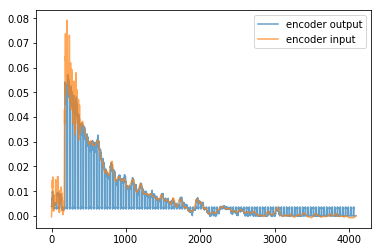

8 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 1.6830119e-04  4.7445355e-05 -1.9426631e-04 ... -3.4439191e-04
 -3.5997099e-04 -3.7248145e-04]


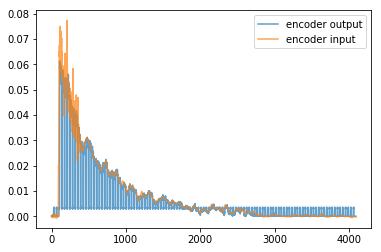

9 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00025033 -0.00075518  0.00025452 ... -0.00020386 -0.00021939
 -0.00023049]


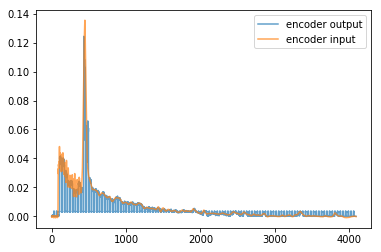

10 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 0.00010575 -0.00045458 -0.00059466 ... -0.00041176 -0.00040793
 -0.00040492]


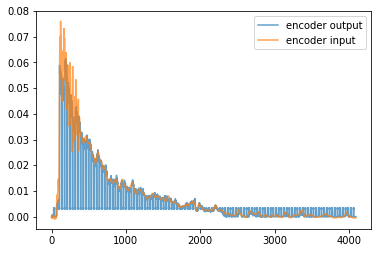

11 (1, 4096) (1, 4096)
[0.00000000e+00 9.06228088e-05 1.05056446e-04 ... 1.99402217e-04
 9.65152867e-06 3.20268795e-04]
[-0.00018304 -0.00053207 -0.00018304 ...  0.00060127  0.00057161
  0.00054537]


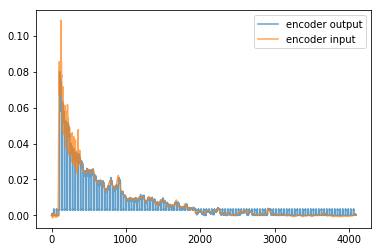

12 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-3.1619449e-05 -6.5130013e-04 -3.4145979e-04 ... -4.8594098e-04
 -4.9471576e-04 -5.0439825e-04]


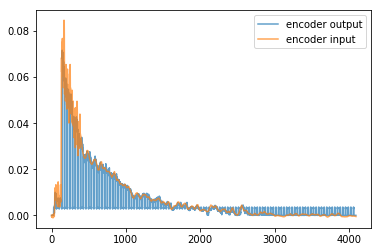

13 (1, 4096) (1, 4096)
[0.         0.0001598  0.         ... 0.00116587 0.00076944 0.00119566]
[-0.00032945 -0.00016052  0.00017734 ...  0.00071036  0.00066087
  0.00060412]


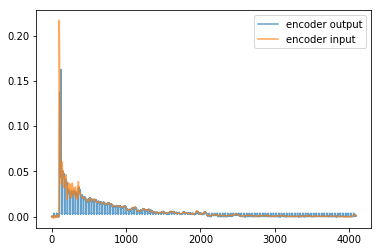

14 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-3.2024062e-04  1.3946928e-04 -1.6700399e-04 ...  9.9663674e-05
  1.0594877e-04  1.1133600e-04]


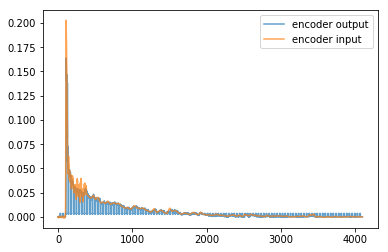

15 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 4.8880527e-05  4.8880527e-05 -7.0950825e-04 ...  3.8511931e-05
  6.1322848e-05  8.7392458e-05]


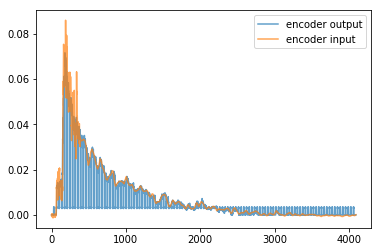

16 (1, 4096) (1, 4096)
[0.         0.00037104 0.00039062 ... 0.         0.         0.        ]
[-0.0005528  -0.00011947 -0.00026391 ... -0.00080077 -0.00080641
 -0.00081121]


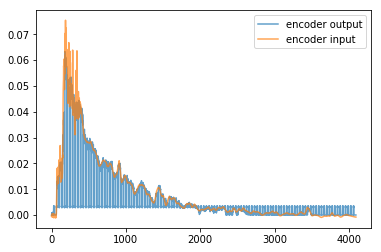

17 (1, 4096) (1, 4096)
[0.         0.         0.         ... 0.00066969 0.00024067 0.00052183]
[ 0.00064238 -0.00060581 -0.00013774 ...  0.00335209  0.0033399
  0.00322288]


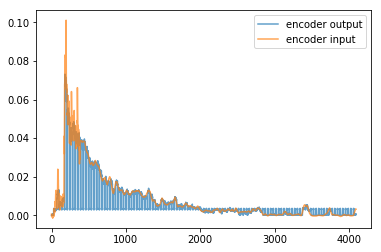

18 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00021649 -0.00076625  0.00019582 ... -0.00049889 -0.0004852
 -0.00046909]


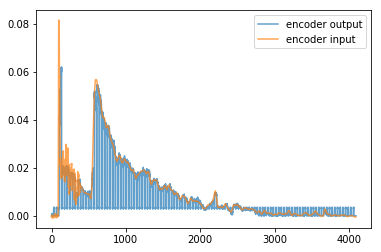

19 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 5.6194636e-04  1.8262331e-04  5.6182285e-05 ... -2.1867875e-04
 -2.2164220e-04 -2.2238307e-04]


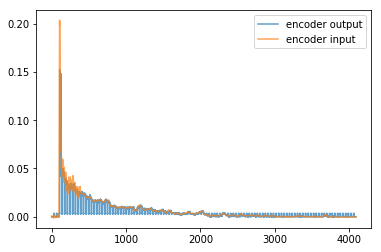

20 (1, 4096) (1, 4096)
[0.0001317  0.00074354 0.00036139 ... 0.         0.         0.        ]
[ 0.00037    -0.00097953 -0.00013607 ... -0.0005013  -0.00052502
 -0.00054512]


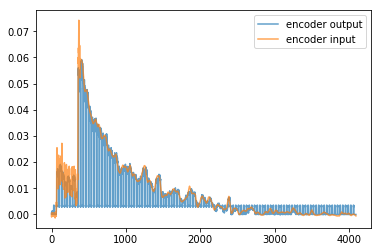

21 (1, 4096) (1, 4096)
[0.0000000e+00 9.4240997e-05 2.9343180e-04 ... 1.3499055e-05 0.0000000e+00
 0.0000000e+00]
[-0.00035207  0.00022274  0.00010778 ... -0.00018547 -0.00018794
 -0.00018861]


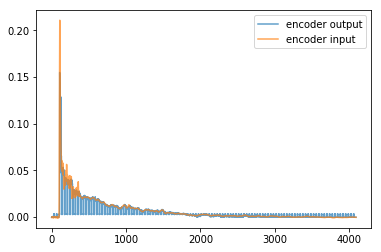

22 (1, 4096) (1, 4096)
[0.00531135 0.00539752 0.00570782 ... 0.         0.         0.        ]
[ 0.00404746  0.00219695  0.00441756 ... -0.00069232 -0.0007028
 -0.00070677]


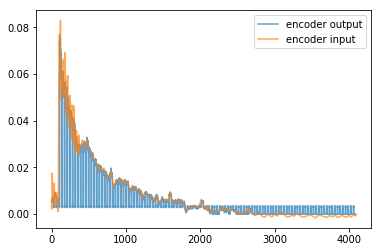

23 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-2.5072086e-04 -2.5072086e-04 -4.0707784e-04 ... -1.1604619e-05
 -1.2215389e-06  1.0688465e-05]


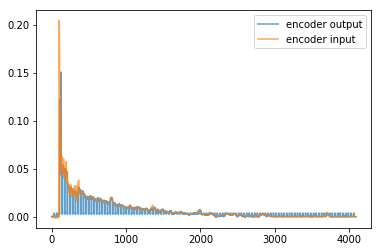

24 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00043232 -0.00121899 -0.00023565 ... -0.00056023 -0.00056945
 -0.00058059]


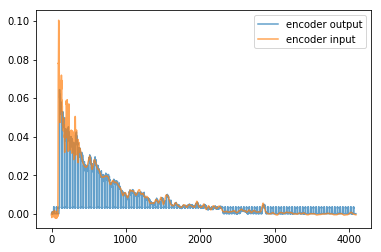

25 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-2.25457552e-04 -5.07176330e-04 -2.25457552e-04 ...  4.47063503e-05
  7.33184133e-05  1.02755825e-04]


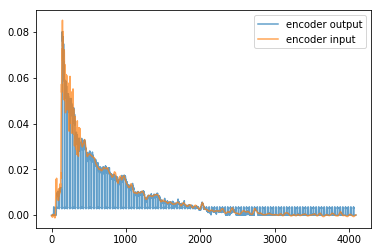

26 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 0.00079675 -0.00025962 -0.00043568 ... -0.00023142 -0.00022076
 -0.00022661]


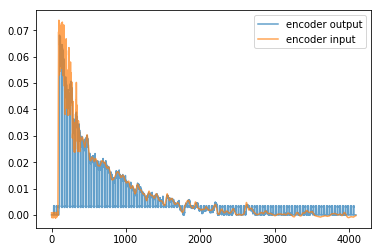

27 (1, 4096) (1, 4096)
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.3546815e-04 0.0000000e+00
 6.6477573e-05]
[-4.3744058e-06 -5.8236037e-04 -1.4887091e-04 ...  2.1180591e-04
  1.9854157e-04  1.8499502e-04]


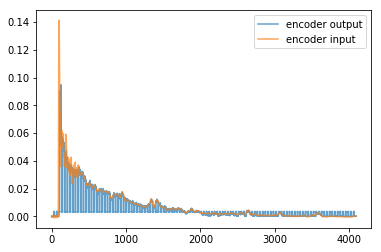

28 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 0.0004323  -0.00154466  0.0004323  ... -0.0007153  -0.00071111
 -0.00070822]


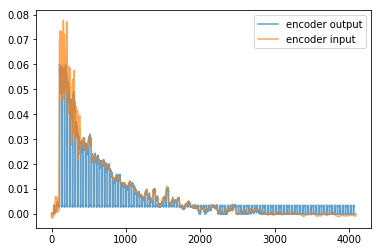

29 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00043846 -0.00091241 -0.00059645 ... -0.00046562 -0.00047487
 -0.00048444]


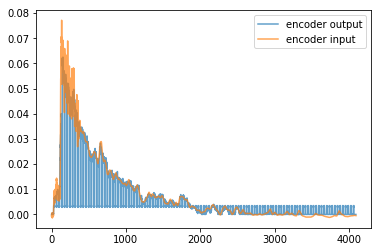

30 (1, 4096) (1, 4096)
[0.0029785  0.00337687 0.0029245  ... 0.         0.         0.        ]
[ 0.00193396  0.00460244  0.00727093 ... -0.00027623 -0.00029534
 -0.00032105]


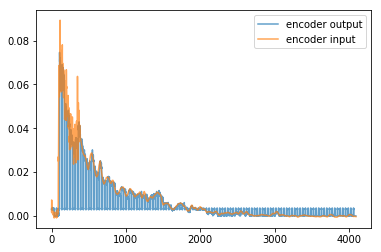

31 (1, 4096) (1, 4096)
[0.         0.         0.         ... 0.00012784 0.         0.        ]
[ 1.4020869e-04 -1.0775495e-03  3.8376034e-04 ...  3.2584547e-05
  2.7827678e-05  2.3546498e-05]


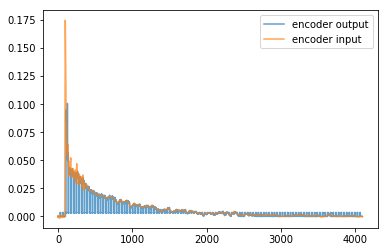

32 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00020906 -0.00118734  0.00028008 ...  0.00081953  0.00080424
  0.00077144]


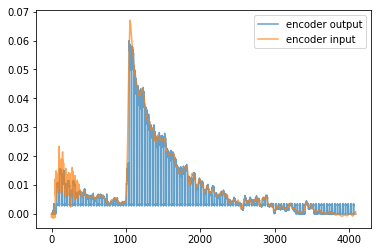

33 (1, 4096) (1, 4096)
[0.00248381 0.00286548 0.0029537  ... 0.         0.         0.        ]
[ 0.00379847  0.00270741  0.00234372 ... -0.00109657 -0.00108271
 -0.00107241]


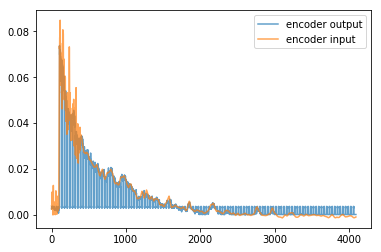

34 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 3.0073745e-04 -4.1080403e-04  1.6120863e-05 ... -6.2398851e-04
 -6.4094324e-04 -6.6151121e-04]


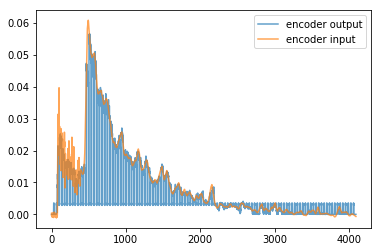

35 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-3.0598344e-04 -1.6407807e-04 -4.4788880e-04 ...  4.4345426e-05
  4.9611444e-05  5.6540415e-05]


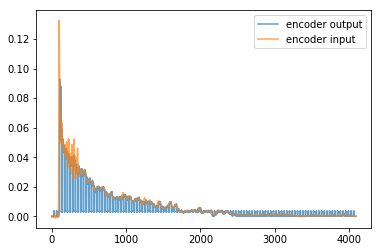

36 (1, 4096) (1, 4096)
[0.         0.00019348 0.00020449 ... 0.         0.         0.        ]
[-8.4747175e-05 -3.8042385e-04  5.0660619e-04 ... -2.1569383e-04
 -2.2031378e-04 -2.2551122e-04]


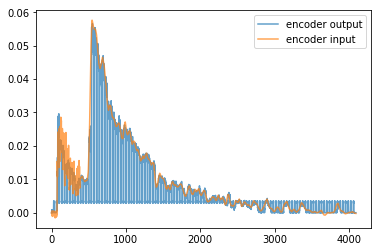

37 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00043401 -0.00011915 -0.00027658 ... -0.0001459  -0.00016004
 -0.00017788]


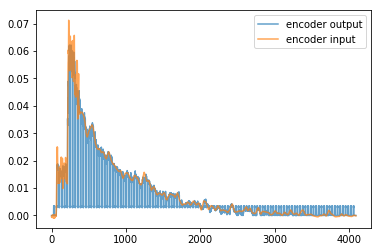

38 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00069739 -0.00025666 -0.00069739 ... -0.00029124 -0.00030271
 -0.00031477]


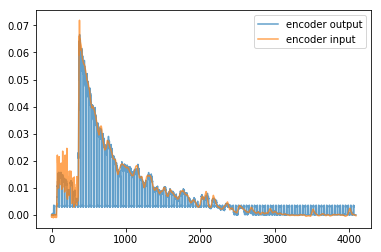

39 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-2.2429622e-04 -4.8693694e-04  3.8344522e-05 ... -1.9877594e-05
 -1.7312745e-05 -1.8082199e-05]


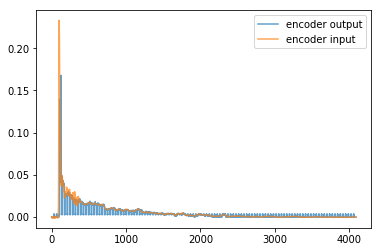

40 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 6.2980229e-04  2.2205674e-04  8.6141554e-05 ... -1.5409915e-04
 -1.6179746e-04 -1.6551389e-04]


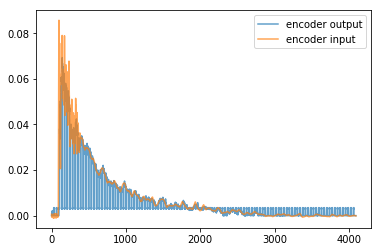

41 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-1.2369204e-04  1.5046520e-04  1.3386584e-05 ...  2.2302050e-04
  2.3024925e-04  2.2623327e-04]


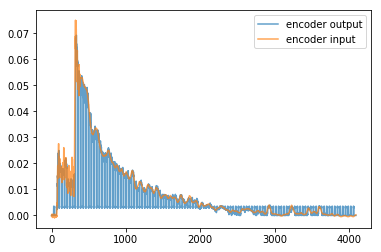

42 (1, 4096) (1, 4096)
[0.00060499 0.00113804 0.00082628 ... 0.         0.         0.        ]
[ 5.5983772e-05 -6.6240446e-04  4.8701672e-04 ... -6.0417573e-04
 -5.9098657e-04 -5.7527184e-04]


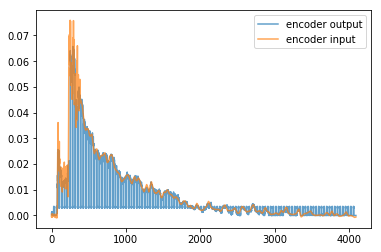

43 (1, 4096) (1, 4096)
[0.000000e+00 9.697769e-05 0.000000e+00 ... 0.000000e+00 0.000000e+00
 0.000000e+00]
[-1.0346392e-03 -3.4950070e-05  3.6492560e-04 ... -2.3508315e-04
 -2.2180603e-04 -2.0930992e-04]


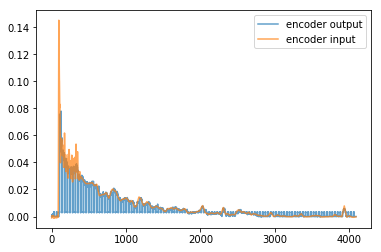

44 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 8.9313529e-05 -4.0327385e-04 -7.4882264e-05 ... -2.0043431e-04
 -2.0877238e-04 -2.1454490e-04]


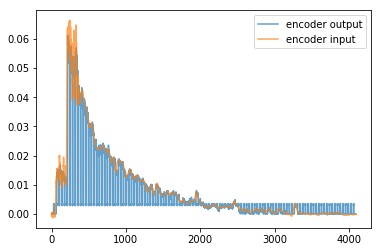

45 (1, 4096) (1, 4096)
[0.00010234 0.00063791 0.00033873 ... 0.         0.         0.        ]
[ 3.29440663e-04 -1.72066633e-04 -1.72066633e-04 ... -1.24070822e-04
 -1.11337235e-04 -9.59916288e-05]


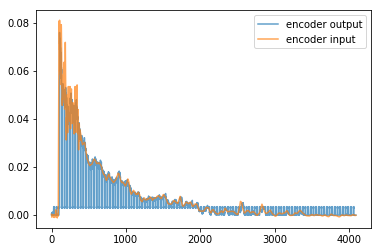

46 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-9.1273530e-04  1.1005505e-05 -5.4323894e-04 ...  5.1256787e-04
  5.3746556e-04  5.5875489e-04]


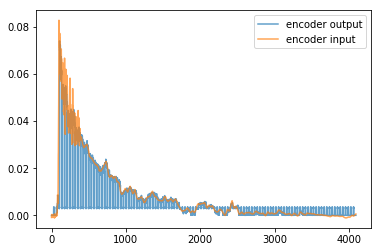

47 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-4.9126538e-04 -2.8614477e-05 -3.3704843e-04 ...  1.5662661e-04
  1.5632540e-04  1.5783143e-04]


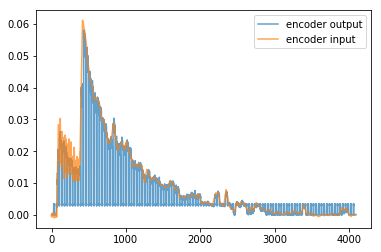

48 (1, 4096) (1, 4096)
[0.         0.00039866 0.00022381 ... 0.00061408 0.00044399 0.00069207]
[ 0.00021625 -0.00012787 -0.00012787 ...  0.00126034  0.00121128
  0.00116289]


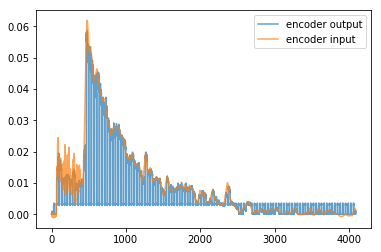

49 (1, 4096) (1, 4096)
[0.00162334 0.00182963 0.00214668 ... 0.         0.         0.        ]
[-0.00116919 -0.00070339 -0.00085866 ...  0.00020879  0.00021546
  0.00020272]


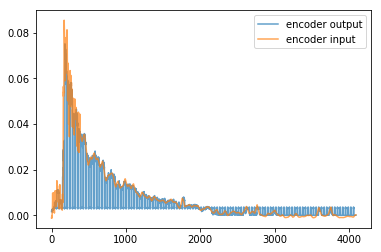

50 (1, 4096) (1, 4096)
[0.         0.         0.         ... 0.00083906 0.00058368 0.00067921]
[-0.00031137 -0.000146   -0.00064213 ...  0.00111952  0.00112179
  0.00111306]


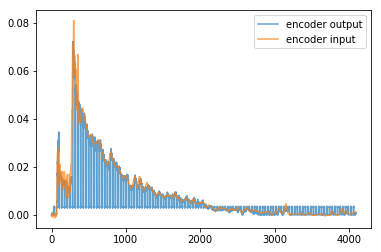

51 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[ 2.1879740e-04 -2.8848232e-04  4.9704166e-05 ...  2.7717091e-03
  2.8866397e-03  3.0019004e-03]


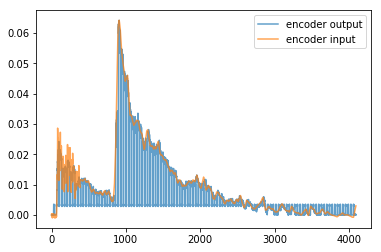

52 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-0.00010369 -0.00041235  0.0003593  ... -0.00023059 -0.00023119
 -0.00023481]


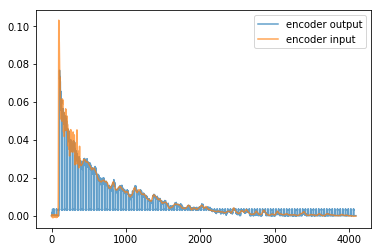

53 (1, 4096) (1, 4096)
[0. 0. 0. ... 0. 0. 0.]
[-7.8101712e-04  3.6712291e-04  3.9082890e-05 ...  5.0615548e-05
  4.6771329e-05  4.6450976e-05]


Process Process-45:
Process Process-44:


Training ended early.


Process Process-43:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/danny/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/danny/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

try:
    for batch_number, (waveform,label) in enumerate(data_loader):

#         print(batch_number,label.size())
#         print(waveform.size())

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        Z = linkage(green)
#         print(Z)
        fig = plt.figure(figsize=(12, 8))
        dn = dendrogram(Z)
        plt.show()
        
        for i, waveform_out in enumerate(feat[0]):
            
            red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform_in[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

            print(i, red.shape,blue.shape)
            print(red[0])
            print(blue[0])
            plt.figure()
            plt.plot(red[0],label="encoder output",alpha=0.7)
            plt.plot(blue[0],label="encoder input",alpha=0.7)
            plt.legend()
            plt.show()
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)

except KeyboardInterrupt:
    print('Training ended early.')
## PLOT the test results



In [ ]:
generated = Features.view(-1,32*14)
print(generated.size())

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(generated[:2000].detach().numpy())
print(db.core_sample_indices_)
print(db.labels_)

In [ ]:
plt.hist(db.labels_)
plt.show()

In [ ]:
whos

# extracting filters/features

Use the protion of the Autoencoder transfer the trained weight to semi-half model of autoencoder.
Uses the output of the midlle layer of autoencoder and do a clustering on it.

The cluster number is a single vector(multi-class in keras?) representing the "output" of the group class.

# How to let this last layer of output automatically deduce itself.?
* save every sample output? how to make gives a supervised like methods output??

#Retrain the network but freeze all layer except for the last layer (clustering analysis layer). this can uses for LWRP studies, identify physical meaning of grouping. with it?

* understanding Neural Network, how to get layer-wise relevance propagation work for the last layer?

In [ ]:
# Discriminator
class Classifier(nn.Module):
    def __init__(self, input_chn, no_classes, kernel_size, 
                 no_filters, padding, maxpool, batch_size):
        super(Classifier, self).__init__()
        self.input_chn = input_chn
        self.no_classes = no_classes
        self.kernel_size = kernel_size
        self.padding = padding
        self.no_filters = no_filters
        self.maxpool = maxpool
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(input_chn)
        self.c1 = nn.Conv1d(input_chn ,no_filters ,kernel_size ,padding=padding )
        self.p1 = nn.MaxPool1d(maxpool ,padding )
        self.lr = nn.LeakyReLU(0.2)
        self.c2 = nn.Conv1d(no_filters, int(no_filters/2), kernel_size, padding=padding)
        self.p2 = nn.MaxPool1d(maxpool ,padding )       
        self.l1 = nn.Linear(4096,64)
        self.h1 = nn.Linear(64,64)
        self.out = nn.Linear(64, no_classes)  
        self.sg = nn.Sigmoid()
        
    def forward(self, inputs):
        
#         x = inputs.view(self.batch_size,1,-1)
#         x = self.norm(x)
        x = self.c1(x)
        x = self.lr(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.lr(x)
        x = self.p2(x)
        
        x = x.view(self.batch_size,-1)
        
        x = self.l1(x)
        x = self.lr(x)
        x = self.h1(x)
        x = self.out(x)
        outputs = self.sg(x)
        return outputs

# Clustering techniques
most likely DBSCAN don't require to specify number of clusters however this can explode making difficult to use, the best option for now

# Layer Wise Relevance Propagation Or similiar techniques
The purpose of understanding CNN, see which portion of data gives more importance, mostly likely create a new CNN using trained weights from autoencoder with the final layers self-created based of the results of clustering. This can allow us to treate this CNN as supervised technique like however in reality as it is based on purely unsupervised techniques. This supervised like technique allows us to use technique like layer wise relevance propagation to understand the CNN giving us insight of the working of features learned by the cNN.